# Convolutional neural network with Keras implemented using Amazon Web Services


Goal: This notebook is a self-tutorial for the purpose of my own education gathering from various sources about convolutional neural networks along with examples. I love to write and want to write down everything as detailed as possible to make sure every concept is clear and understood properly.

It is a tradition to start with hand-written digit classification using MNIST dataset. The MNIST data set and MNIST digit classification problem is describle [here](http://yann.lecun.com/exdb/mnist/).


## 1. Get familar with MNIST dataset
Let load the MNIST dataset and plot some images to get comfortable with it.

Using TensorFlow backend.


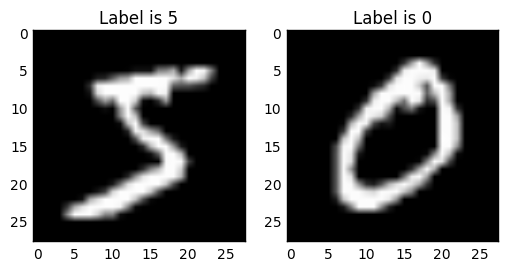

In [11]:
# import the built-in function to get MNIST dataset
from keras.datasets import mnist
# import matplotlib to flot some images
import matplotlib.pyplot as plt

# import numpy to play with the data set as well
import numpy as np

# downloand the MNIST dataset and split into (x,y_) for training and (x_test,y_test) for testing. x is the flatten
# pixel values of each images and y_ is corresponding labels.

(x,y_),(x_test,y__) = mnist.load_data()

# plot first two gray-scale images and their labels

fig = plt.figure()

ax = plt.subplot(121)
ax.set_title('Label is {label}'.format(label=y_[0]))
ax.imshow(x[0], cmap=plt.get_cmap('gray'))

ax = plt.subplot(122)
ax.set_title('Label is {label}'.format(label=y_[1]))
ax.imshow(x[1], cmap=plt.get_cmap('gray'))

# show the plot
plt.show()

In [12]:
# get familiar with data set
print ('The x data type is {}.'.format( type(x)))
print ('Its dimension is {}.'.format( x.shape))
print ('Maximum and minimum values are {} and {},repsectively.'.format( np.amax(x),np.amin(x)))
print ('Label is a {}-long vector consist of 10 classes of integers in [{},{}]'\
       .format(y_.shape,np.amin(y_),np.amax(y_)))

The x data type is <type 'numpy.ndarray'>.
Its dimension is (60000, 28, 28).
Maximum and minimum values are 255 and 0,repsectively.
Label is a (60000,)-long vector consist of 10 classes of integers in [0,9]


So, as expected, x is 3-dimensional numpy ndarray (tensor if you will). There are 60000 images in x, and each image has 28 pixels wide and 28 pixels high. They are 8-bit gray-scale images there for the fixel values are from 0-255.

## 2. Preprocessing images so that Keras backend can understand

### 2.1. Input image data structure
Normally, depend on backend used, Keras expects an image dataset as a tensor (numpy ndarrayt) consisting of 4 dimensions: [sample #][width][height][channel] for Tensorflow backend (for Theano backend, the order is:  [sample #][channel][width][height]). Each datapoint is the *pixel value* where:

* [sample #] : the ordering number of the image in the dataset that the pixel belong to
* [width] : horizontal coordinate of the pixel
* [height] : verticaal coordinate of the pixel
* [channel] : color chanel or the image, MNIST images are gray-scale so chennal is always 1. If the input is RGB color images, channel takes values 1,2,or 3 for red, green, or blue components.

### 2.2. Preprocessing steps
Now, let's do 3-step processing on our MNIST images so that the Keras can understand:
1. shape the input image shape into the format used by Keras backend.
2. normalize gray-scale values from [0,255] (int) to [0,1] (float32)to make sure the values of neural network aren't getting too big.
3. explode the  each label value to binary class vector (1-hot vector), e.g., label 0 now becomes [1,0,0,0,0,0,0,0,0,0].*


* remember that y_ consists of 60000 labels taking interger values from 0 to 9? It means after exploding each to binary vector the label data becomes a 6000x10 matrix.



In [13]:
# Step 1: reshape the image to the format [sample #][width][height][channel] for Tensorflow backend
x = x.reshape(x.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')
# let see the new shape
print('The new shape of input dataset {} and its data type is {}.'. format(x.shape,x.dtype))

The new shape of input dataset (60000, 28, 28, 1) and its data type is float32.


In [14]:
# Step 2: Normalize the pixel gray-scale values
x = x/255
x_test = x_test/255

In [15]:
# Step 3: Explode the label values to binary vector. To do this we need an utility. 
from keras.utils import np_utils

y_train = np_utils.to_categorical(y_)
y_test = np_utils.to_categorical(y__)
print('The new shape of label dataset {} consisting of {} samples and {} classes.'.\
      format(y_train.shape,y_train.shape[0],y_train.shape[1]))


The new shape of label dataset (60000, 10) consisting of 60000 samples and 10 classes.


## 3. Building blocks of a convolutional neural network (CNN) model 
A CNN consists of a sequence of one or more of the following layers: input, convolutional, pooling, flatten, fully-connected, and softmax layers. The process of choosing how many layers and how to stack them is called design a CNN architecture or network topology. In what follows, we will explore convolutiinal, pooling layers and what they do *intuitively*. Next, we will arrange these layers in a sequence to get a model.
### 3.1. Convolutional layer

A covulutional layer consists of two elements: a filter and a set of output maps. 

* A fiter is a tensor, typically much smaller size than input, consist of learnable weights. Filter size is a tuning variable.
* Output map is the results of applying a filter to different parts of input tensor (multiply element-wise weights to values of the input). It is often that the stride size is smaller than the size of filters so that applications are overlapped. Output map size depends on how we apply the filter (stride), of filters, input dimension, padding. 

Now lets take an example:
 
 Let use 3 filters each has size 1x5x5 (often filter's depth is equal to the depth of input image, in this case, 1). Use stride size of 1. Each input image is a 1x28x28 tensor, thus, applying each filter results in an output map of dimension 24x24 calculated as (28-5)/1+1=24.If we use 3 filters, then there are 3 output maps corresponding to each filter. Thus, convolutional layer outputs a tensor of 3x24x24 for each image. Finally, we input 60000 images, therefore, the output has a dimension of 60000x3x24x24 (figure 1).

<img src="Convolutional_layer.jpg">

 *Figure 1:* An example of a convolutional layer.

### 3.2. Pooling layer
Pooling layer is a much simpler version of the convolutional layer. It has 1 receptive field (filter) and an output map. Pooling operation outputs a tensor that approximates all information of its input but is smaller in size by consecutively using a summary statistics (average or maximum) to different parts of the input. As the results, pooling is thought as a technique to compress the information from previous layer.
<img src="Pooling_layer.jpg">

 *Figure 2:* An example of a pooling layer.


### 3.3. Other layers

Activation layers apply actiovation function (relu, sigmoid, tanh, etc) to the output of convolutional or fully connected layers.
Flatten layer converts previous layer (could be a tensor) to vectors. This is an intermediate step to input data into fully connected layer.

These layers are standard and I already understood, I will not cover them in details.

## 4. Build, compile, train, and evaluate a CNN model

### 4.1. Tuning parameters
Before we build a model, it is convenient to define tuning paremeters that will be fed into the model. In this way, we have a neat control over papermeters and it is easy to experiment with different sets of parameters.


There are so many tuning parameters that affect performance of the network. For this particular example, let's control batch size, number of epoches, number of convolutional filter (receptive field), filter size, and pooling size. Let's assign these parameter to variables:

In [16]:
# batch size
batch = 128
# number of epoches
epoch = 12
# number of convolutional filters
filters = 32
# convolution filter size
filter_size = (3, 3)
# pooling size
pooling_size = (2, 2)


### 4.2. Builing and compile a CNN model
#### 4.2.1. Building a CNN model

There are many architectures we can choose to construct a CNN such as LeNet, AlexNet, VGG, ResNet,etc. For simplicity, let's consider [this](https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py) network architecture.

<img src="CNN_1.jpg">

 *Figure 3:* An example of a CNN.
 
 
 The Keras code:

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D


# CNN is a sequential model
model = Sequential()

# Layer struture:

# Conv 1: First convolutional layer. Arguments: number of filters, filter size, padding mode, input structure.
model.add(Convolution2D(filters, filter_size[0], filter_size[1],
                        border_mode='valid',input_shape=(28,28,1)))
# Activ1: First activation layer using relu activation function.
model.add(Activation('relu'))
# Conv 2: Second convolutional layer.
model.add(Convolution2D(filters, filter_size[0], filter_size[1]))
# Activ2: Second activation layer using relu activation function.
model.add(Activation('relu'))
# MaxPool1: First pooling layer using maxpooling method, Argument: pooling size.
model.add(MaxPooling2D(pool_size=pooling_size))
# Dropout1: First dropout layer. Drop (set to zero) 25% of neurons.
model.add(Dropout(0.25))
# Flatten1: First flatten layer.
model.add(Flatten())
# FC1: First fully connected layer.
model.add(Dense(128))
# Activ 3: Third activation layer using relu activation function.
model.add(Activation('relu'))
# Dropout2: Second dropout layer. Drop (set to zero) 50% of neurons.
model.add(Dropout(0.5))
# FC2: Second fully connected layer.
model.add(Dense(10))
# Activ 3: Forth activation layer using softmax activation function.
model.add(Activation('softmax'))

#### 4.2.2. Compile a CNN model
Now, we already had a model frame, we need to compile it, in particular, we need to have a loss function, an optimizer, and metric to evaluate traing performace.

In [21]:
# compile model by specifying loss function, opimizer, and evaluation metric. In fact, optimizer could 
# a hyperparemet to experiment with
model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

#### 4.2.3. Training and evaluating a CNN model
Let's put all together data, tuning parameters, complied mode to train.

In [ ]:
model.fit(x, y_train, batch_size=batch, nb_epoch=epoch,verbose=1, 
          validation_data=(x_test, y_test))
result = model.evaluate(x_test, y_test, verbose=0)
print('Test result is {} and test accuracy is {}'.format(result[0],result[1]))

## 5. (Optional) Execute the training process using AWS
I follow [this](http://cs224d.stanford.edu/supplementary/aws-tutorial-2.pdf) tutorial from Stanford CS224d Class to setup AWS and run the instance, except for I use the community image machine: ami-125b2c72 (for CS231n class).

Basically, there are main steps as follows:
1. Sign in AWS and run EC2 instance.
2. Choose ami-125b2c72 community AMI:
<img src="Ami.png">
3. Choose the following GPU configuration:
<img src="GPU.png">
4. Select a keypair or create a keypair and launch the instance.
5. Copy the public IP address
<img src="IP.png">
6. Open a terminal and ssh to the EC2 instance by using the public IP:
ssh -i keras_keypair.pem ubuntu@
7. If you see the following screen, it means you are connected to your server and running the instance you launched before:
<img src="Instance.png">
8. Moving file to the  ECS instance. You will need path to your .pem file, path to files you wnat to move and ECS instance's pbluc DNS. Follow [this](http://docs.aws.amazon.com/AWSEC2/latest/UserGuide/AccessingInstancesLinux.html) guide. Note: remember that you have to open another local terminal in order to copy file and data because the current terminal is running on EC2 instance.  The comman is:
scp -i /path/keypair.pem -r /path/your_file ubuntu@publicDNS:~/
9. Using vi to config ./theanorc file as follows:
<img src="Theano_config.png">
10. From the terminal on EC2, execute your python command.
<img src="GPU_EC2.png">
As you can see the computation is much much faster than excution on a PC with CPU device.





Finally, you find that the accuracy is 99.07% after 25 epoches!

## 6. Notes on reproducibility 

For convenient, I wrote the tutorial in IPthon Notebook but run the script on AWS. The scipt is as follows. For reproducibility, just copy the script to, say CNN_MNIST.py file, upload to EC2 and use command: python CNN_MNIST.py (note that I have changed input data structure to use Theano backend.)


In [ ]:

# import the built-in function to get MNIST dataset
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D


# import numpy and seed for reproducibility
import numpy as np
np.random.seed(64)
# downloand the MNIST dataset and split into (x,y_) for training and (x_test,y_test) for testing.
# x is pixel values of each images and y_ is corresponding labels.

(x,y_),(x_test,y__) = mnist.load_data()

#%% Data preprocess
# Step 1: reshape the image to the format [sample #][width][height][channel] for Theano backend
from keras import backend as K
K.set_image_dim_ordering('th')
x = x.reshape(x.shape[0], 1, 28, 28).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28).astype('float32')

# Step 2: Normalize the pixel gray-scale values
x = x/255
x_test = x_test/255
# Step 3: Explode the label values to binary vector. To do this we need an utility. 
from keras.utils import np_utils

y_train = np_utils.to_categorical(y_)
y_test = np_utils.to_categorical(y__)
print(x.shape[0], 'training exmples')
print(x_test.shape[0], 'test samples')

#%%
# batch size
batch = 128
# number of epoches
epoch = 25
# number of convolutional filters
filters = 32
# convolution filter size
filter_size = (3, 3)
# pooling size
pooling_size = (2, 2)
#%%

# CNN is a sequential model
model = Sequential()

# Layer struture:

# Conv 1: First convolutional layer. Arguments: number of filters, filter size, padding mode, input structure.
model.add(Convolution2D(filters, filter_size[0], filter_size[1],
                        border_mode='valid',input_shape=(1,28,28)))
# Activ1: First activation layer using relu activation function.
model.add(Activation('relu'))
# Conv 2: Second convolutional layer.
model.add(Convolution2D(filters, filter_size[0], filter_size[1]))
# Activ2: Second activation layer using relu activation function.
model.add(Activation('relu'))
# MaxPool1: First pooling layer using maxpooling method, Argument: pooling size.
model.add(MaxPooling2D(pool_size=pooling_size))
# Dropout1: First dropout layer. Drop (set to zero) 25% of neurons.
model.add(Dropout(0.25))
# Flatten1: First flatten layer.
model.add(Flatten())
# FC1: First fully connected layer.
model.add(Dense(128))
# Activ 3: Third activation layer using relu activation function.
model.add(Activation('relu'))
# Dropout2: Second dropout layer. Drop (set to zero) 50% of neurons.
model.add(Dropout(0.5))
# FC2: Second fully connected layer.
model.add(Dense(10))
# Activ 3: Forth activation layer using softmax activation function.
model.add(Activation('softmax'))
#%%
# compile model by specifying loss function, opimizer, and evaluation metric. In fact, optimizer could 
# a hyperparemet to experiment with
model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])
model.fit(x, y_train, batch_size=batch, nb_epoch=epoch,verbose=1, 
          validation_data=(x_test, y_test))
result = model.evaluate(x_test, y_test, verbose=0)
print('Test result is {} and test accuracy is {}'.format(result[0],result[1]))




## 7. What is next?
My next step  is using OpenCV to capture and import a hand-written digit image and feed it to the classifier.